In [66]:
%matplotlib inline
import os
import functools
import IPython

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.table import Table
from astropy.io import fits

from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter

import stuff

## Configuration

### Conf file

In [2]:
print(open(os.path.expanduser('~/Work/Data/sim08/test_py.config')).read())

output-properties=WorldCentroid,PixelCentroid,SourceIDs,AutoPhotometry
#,FlexibleModelFitting
#,AutoPhotometry
detection-image=/home/aalvarez/Work/Data/sim08/coadd.fits
weight-image=/home/aalvarez/Work/Data/sim08/coadd.weight.fits
weight-type=weight
detection-image-saturation=59000
detection-image-gain=1
detect-minarea=10
partition-min-area=10
threads-nb=4
cellsize-value=32
partition-multithreshold=true
grouping-algorithm=SPLIT
checkimage-residual=/home/aalvarez/Work/Data/sim08/mci_residual.fits
checkimage-modelfitting=/home/aalvarez/Work/Data/sim08/mci_modelfitting.fits
checkimage-background=/home/aalvarez/Work/Data/sim08/mci_background.fits
checkimage-variance=/home/aalvarez/Work/Data/sim08/mci_variance.fits
checkimage-segmentation=/home/aalvarez/Work/Data/sim08/mci_segmentation.fits
checkimage-partition=/home/aalvarez/Work/Data/sim08/mci_partition.fits
checkimage-filtered=/home/aalvarez/Work/Data/sim08/mci_filtered.fits
checkimage-aperture=/home/aalvarez/Work/Data/sim08/mci_aperture

### Python file

In [3]:
py_content = open('/home/aalvarez/Work/Projects/SExtractorxx/tests/test_config.py').read()
formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(formatter.get_style_defs('.highlight'), highlight(py_content, PythonLexer(), formatter)))

## Input

In [4]:
detection_img = fits.open('/home/aalvarez/Work/Data/sim08/coadd.fits')[0].data
detection_weight = fits.open('/home/aalvarez/Work/Data/sim08/coadd.weight.fits')[0].data

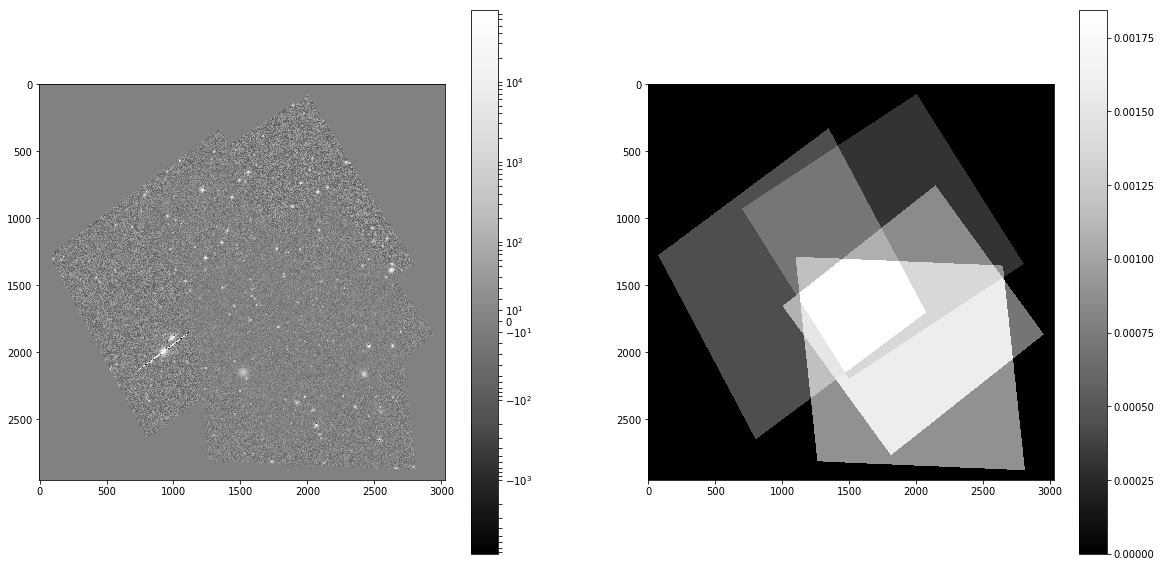

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
detection_fig = axes[0].imshow(detection_img, cmap=plt.get_cmap('Greys_r'), norm=colors.SymLogNorm(50))
fig.colorbar(detection_fig, ax=axes[0])
weight_fig = axes[1].imshow(detection_weight, cmap=plt.get_cmap('Greys_r'))
fig.colorbar(weight_fig, ax=axes[1])

## Output

In [6]:
catalog = Table.read('/home/aalvarez/Work/Data/sim08/py_output.fits')

In [7]:
catalog.colnames

['aperture_i_flux',
 'aperture_r_flux',
 'aperture_i_flux_err',
 'aperture_r_flux_err',
 'aperture_i_mag',
 'aperture_r_mag',
 'aperture_i_mag_err',
 'aperture_r_mag_err',
 'aperture_i_flags',
 'aperture_r_flags',
 'world_centroid_alpha',
 'world_centroid_delta',
 'pixel_centroid_x',
 'pixel_centroid_y',
 'source_id',
 'detection_id',
 'auto_flux',
 'auto_flux_err',
 'auto_mag',
 'auto_mag_err',
 'auto_flags']

In [8]:
# I band has two images, and two apertures
print(catalog['aperture_i_flux'].shape)
# R band has two images, and three apertures
print(catalog['aperture_r_flux'].shape)

(753, 2, 2)
(753, 2, 3)


In [9]:
i_outside = (catalog['aperture_i_flags'] & stuff.SourceFlags.OUTSIDE).astype(np.bool)
i_boundary = (catalog['aperture_i_flags'] & stuff.SourceFlags.BOUNDARY).astype(np.bool)

In [10]:
# First element is inside of the first image of the I band
print(i_outside[0,0])
# First element is outside of the second image of the I band
print(i_outside[0,1])

aperture_i_flags
----------------
           False
           False
aperture_i_flags
----------------
            True
            True


More generally, plot over the detection image wether a source is outside of which image for the first aperture

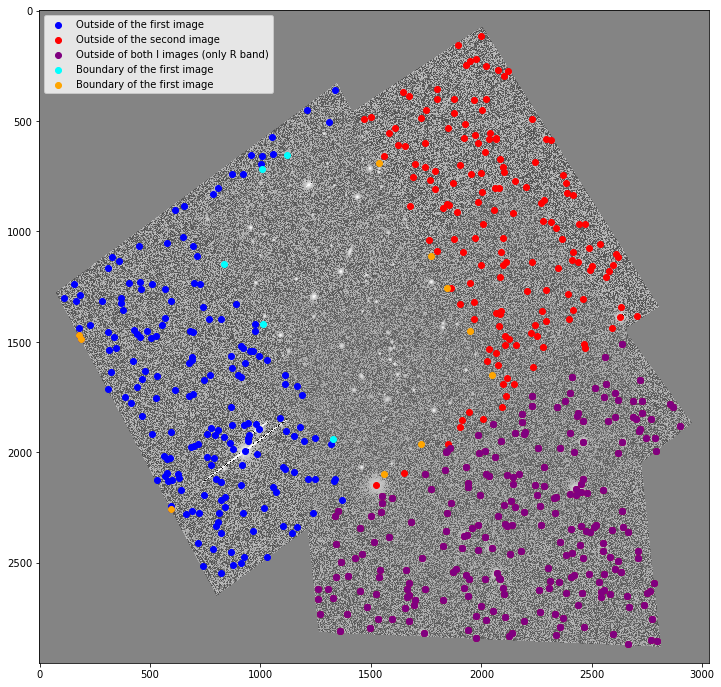

In [11]:
outside_first = catalog[i_outside[:,0,0]]
outside_second = catalog[i_outside[:,1,0]]
outside_both = catalog[np.logical_and(i_outside[:,0,0], i_outside[:,1,0])]
boundary_first = catalog[i_boundary[:,0,0]]
boundary_second = catalog[i_boundary[:,1,0]]
plt.figure(figsize=(12,12))
plt.imshow(detection_img, cmap=plt.get_cmap('Greys_r'), norm=colors.SymLogNorm(10))
plt.scatter(outside_first['pixel_centroid_x'], outside_first['pixel_centroid_y'], c='blue', label='Outside of the first image')
plt.scatter(outside_second['pixel_centroid_x'], outside_second['pixel_centroid_y'], c='red', label='Outside of the second image')
plt.scatter(outside_both['pixel_centroid_x'], outside_both['pixel_centroid_y'], c='purple', label='Outside of both I images (only R band)')
plt.scatter(boundary_first['pixel_centroid_x'], boundary_first['pixel_centroid_y'], c='cyan', label='Boundary of the first image')
plt.scatter(boundary_second['pixel_centroid_x'], boundary_second['pixel_centroid_y'], c='orange', label='Boundary of the first image')
plt.legend()

Different apertures for the same image and the same source should have different fluxes, and maybe even different flags.
Let's focus on the first image of the I band.

In [17]:
# The first is smaller, so necessarely must be inside the second if inside the first
i_first_inside = np.logical_not(catalog['aperture_i_flags'] & stuff.SourceFlags.OUTSIDE).astype(np.bool)[:,0,0]
i_first_inside = catalog[i_first_inside]

In [20]:
print(f"{len(i_first_inside)} out of {len(catalog)} inside of the first I image")

340 out of 753 inside of the first I image


In [32]:
i_first_fluxes = i_first_inside['aperture_i_flux'][:,0,:]
i_first_flags = i_first_inside['aperture_i_flags'][:,0,:]

Are there any fluxes for aperturees 5 and 20 close?

In [31]:
np.isclose(i_first_fluxes[:,0], i_first_fluxes[:,1]).any()

False

Are all flags equal for both apertures?

In [38]:
np.all(i_first_flags[:,0] == i_first_flags[:,1])

False

No, let's find out who and what is different

In [45]:
i_different_flags = i_first_inside[i_first_flags[:,0] != i_first_flags[:,1]]['aperture_i_flags'][:,0,:]
print(len(i_different_flags))

27


In [72]:
pretty_flag = []
for i in np.bitwise_xor(i_different_flags[:,0], i_different_flags[:,1]):
    pretty_flag.append(
        functools.reduce(lambda a,b: a|b, [stuff.SourceFlags(f & i) for f in stuff.SourceFlags], stuff.SourceFlags(0))
    )

In [73]:
pretty_flag

[<SourceFlags.BOUNDARY: 8>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS|BOUNDARY: 24>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.BOUNDARY: 8>,
 <SourceFlags.NEIGHBORS: 16>,
 <SourceFlags.NEIGHBORS: 16>]

Makes sense. The flags that change are either the boundary flag, or the neighbour flag. Both depend on the size of the aperture!